# Stage 11: Evaluation & Risk under Assumptions
*Applied Financial Engineering Lifecycle (Aug 25, Mon)*

## Objectives
- Evaluate model predictions under uncertainty
- Identify how assumptions affect results
- Compare scenarios (missing data, model form, distributional assumptions)
- Communicate risk and sensitivity clearly to stakeholders
- Use bootstrap and CI visualizations to illustrate uncertainty

**Mindset:** Credibility over confidence. Ask: *What if our assumptions are wrong?*

## Teaching Tip:
Introduce this stage with a discussion: "Why do assumptions matter?" Use a real-world example of risk misestimation.

In [9]:
# Imports & Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
np.random.seed(11)
plt.rcParams['figure.figsize'] = (8, 5)

## Data: Load or Generate
Check for existing CSV; if missing, generate synthetic data with some NaNs.

In [10]:
data_dir = Path('data')
data_dir.mkdir(parents=True, exist_ok=True)
csv_path = data_dir / 'data_stage11_eval_risk.csv'

if csv_path.exists():
    df = pd.read_csv(csv_path)
else:
    x = np.linspace(0, 10, 80)
    y = 2.5 * x + 3 + np.random.normal(0, 3, size=x.size)
    df = pd.DataFrame({'x': x, 'y': y})
    # Introduce random missing values
    df.loc[np.random.choice(df.index, 5), 'y'] = np.nan
    df.to_csv(csv_path, index=False)

df.head()

,x,y
0,0.000000,8.248364
1,0.126582,2.458237
2,0.253165,2.179216
3,0.379747,-4.010589
4,0.506329,4.240969


## Visual Check for Missing Values
Inspect data quality before modeling.

### Teaching Tip:
Highlight to students that missing data is common and must be handled deliberately.

Missing values: {'x': 0, 'y': 4}


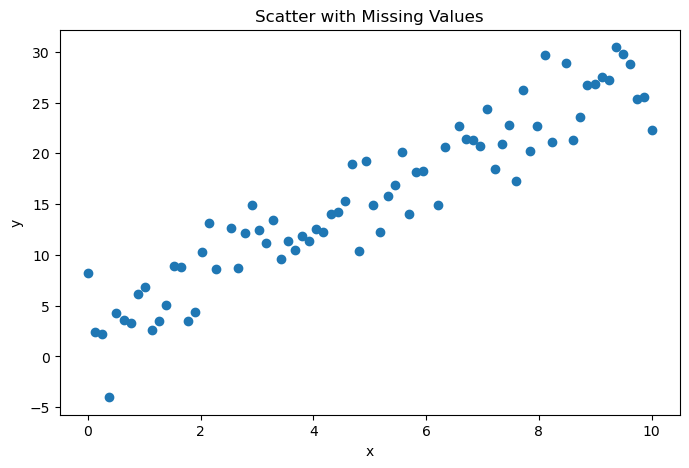

In [11]:
print('Missing values:', df.isna().sum().to_dict())
plt.scatter(df['x'], df['y'])
plt.title('Scatter with Missing Values')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Scenario 1: Fill Method Assumptions
📌 Compare Mean Fill vs Median Fill vs Dropping Missing Data

### Teaching Tip:
Discuss with students how choice of fill method represents an assumption about the missing data mechanism.

In [12]:
df_mean = df.copy()
print(df['y'].mean())
df_mean['y'] = df_mean['y'].fillna(df['y'].mean())

df_med = df.copy()
print(df['y'].median())
df_med['y'] = df_med['y'].fillna(df['y'].median())

print(np.nan)
df_drop = df.dropna()
print("")

def fit_lin(d):
    m = LinearRegression().fit(d[['x']], d['y'])
    return float(m.coef_[0]), float(m.intercept_)

s_mean, i_mean = fit_lin(df_mean)
s_med, i_med = fit_lin(df_med)
s_drop, i_drop = fit_lin(df_drop)

print('Mean Fill:', s_mean, i_mean)
print('Median Fill:', s_med, i_med)
print('Drop NA:', s_drop, i_drop)

15.514463575309264
14.93608621181718
nan

Mean Fill: 2.4974276962851127 3.0273250938837
Median Fill: 2.4946429163868173 3.012330125200572
Drop NA: 2.578162669102187 2.7352961814916306


📌 **Observation:** Different fill strategies result in slightly different slopes and intercepts.
- Mean fill pulls toward the average.
- Median fill resists skew.
- Dropping reduces sample size.

👉 Communicate: *“Handling missing data changes risk conclusions.”*

## Scenario 2: Linear vs Polynomial Regression
📌 Compare model forms and their impact on conclusions

### Teaching Tip:
Encourage students to visualize both linear and nonlinear fits to illustrate overfitting vs underfitting.

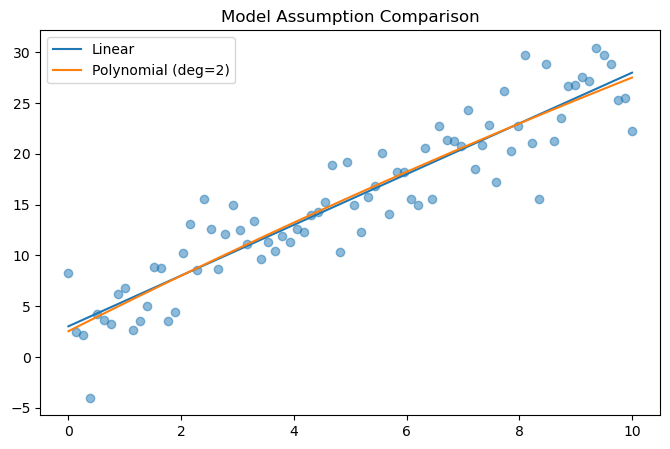

In [13]:
X = df_mean[['x']]
y = df_mean['y']

lin = LinearRegression().fit(X, y)
poly = make_pipeline(PolynomialFeatures(2), LinearRegression()).fit(X, y)

plt.scatter(X, y, alpha=0.5)
plt.plot(X, lin.predict(X), label='Linear')
plt.plot(X, poly.predict(X), label='Polynomial (deg=2)')
plt.legend()
plt.title('Model Assumption Comparison')
plt.show()



📌 **Observation:** Polynomial captures curvature but may overfit.
👉 Stakeholders must understand that conclusions can shift with a shift in models.

## Scenario 3: Gaussian vs Bootstrapped Confidence Intervals
📌 Compare distributional assumptions for prediction uncertainty

### Teaching Tip:
Illustrate that Gaussian CI can underestimate risk in presence of fat tails; bootstrap provides a more robust alternative.

In [14]:
#ci_boot

#Illustrate that Gaussian CI can underestimate risk in presence of fat tails; bootstrap provides a more robust alternative.


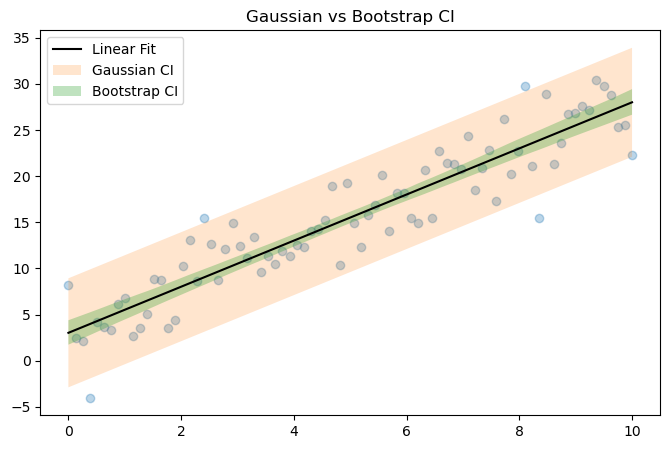

In [15]:
# Predict on full X
y_hat = lin.predict(X)
resid = y - y_hat
sigma = resid.std()

# Gaussian CI (over X, not confidence interval of X itself)
# Builds a 95% confidence interval using ±1.96 × standard deviation.
# Assumes prediction errors are normally distributed.
# This is a quick and theoretical method — doesn't use resampling.
ci_gauss = (y_hat - 1.96*sigma, y_hat + 1.96*sigma)

# Bootstrap CI
boot_preds = []
for _ in range(500):
    #Take a bootstrapped sample of rows from df_mean: a full-size sample with replacement.
    #Introduces variation like a real-world sampling error.   
    # fac=1 => 100% of the original dataset size, (but with replacement)
    sample = df_mean.sample(frac=1, replace=True)
    m = LinearRegression().fit(sample[['x']], sample['y'])
    boot_preds.append(m.predict(X))  # X is 200-length
boot_preds = np.array(boot_preds)

# For each x value, compute the 2.5th and 97.5th percentiles across all 500 predictions.
# This gives a 95% bootstrap confidence interval for each point in X.
ci_boot = (
    np.percentile(boot_preds, 2.5, axis=0),
    np.percentile(boot_preds, 97.5, axis=0)
)

# Plot
plt.scatter(X, y, alpha=0.3)
plt.plot(X['x'], y_hat, color='black', label='Linear Fit')
plt.fill_between(X['x'], ci_gauss[0], ci_gauss[1], alpha=0.2, label='Gaussian CI')
plt.fill_between(X['x'], ci_boot[0],  ci_boot[1],  alpha=0.3, label='Bootstrap CI')
plt.legend()
plt.title('Gaussian vs Bootstrap CI')
plt.show()


📌 **Observation:** Gaussian CI is narrower than bootstrap CI.
👉 Message: *“Risk is underestimated if we assume Gaussian errors.”*

## Wrap-Up & Communication
- Different assumptions change outputs.
- Communicate not just results, but how assumptions affect them.
- Side-by-side comparisons support transparent risk discussions.
- Document assumption dependence and use scenario analysis to build stakeholder trust.

### Teaching Tip:
End the session with a discussion: "How would stakeholders react if these assumptions were wrong?"

## Idea
Sampling: Bootstraps your data with replacement (simulate alternative datasets).
Preprocessing: Applies your exact cleaning and transformation logic on each sample.
Modeling: Fits your model on processed data.
Metric extraction: Pulls out whatever summary number you care about (slope, accuracy, etc).
CI estimation: Returns a 95% confidence interval reflecting uncertainty from data sampling + pipeline.

How to adapt it to your own use:
Make preprocess() do your real missing value handling, filtering, normalization, outlier trimming, or whatever assumptions you want.
Replace fit_model() with your actual modeling code.
Change extract_slope() to compute your final metric or summary statistic.
Optionally increase n_bootstrap for tighter CI at the cost of longer computation.